Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Preprocessed Image Set 1


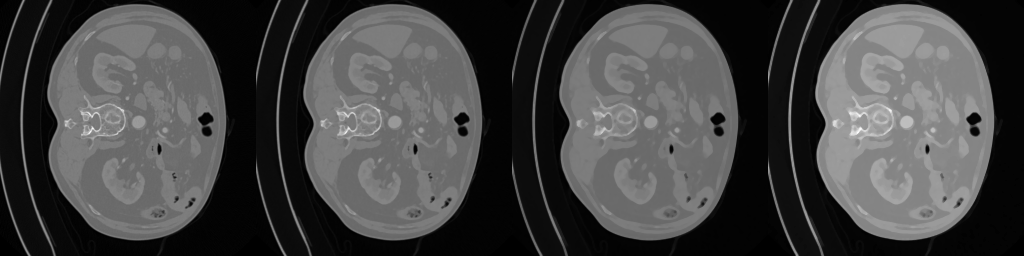

Preprocessed Image Set 2


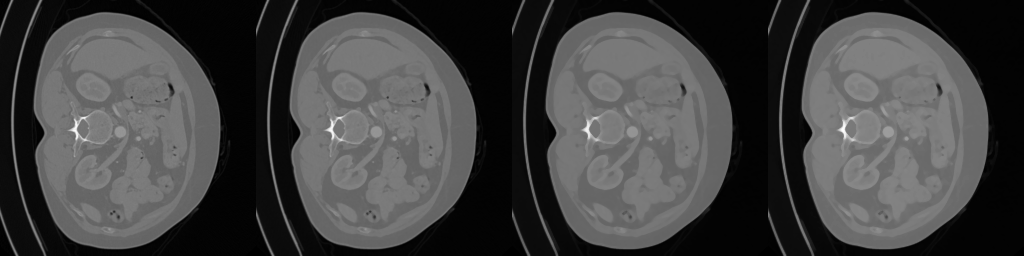

Preprocessed Image Set 3


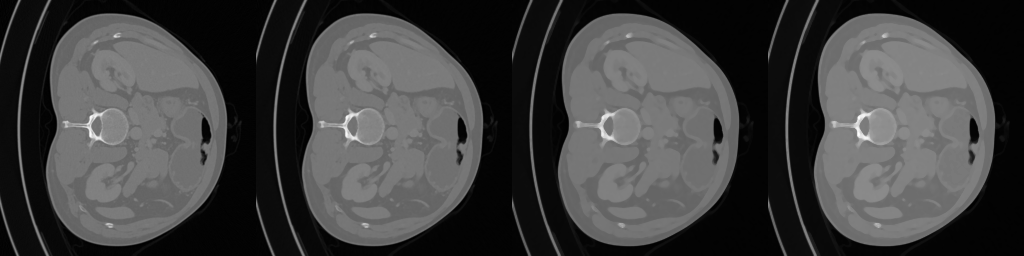

In [35]:
# Gerekli kütüphaneler
import cv2
import numpy as np
from skimage.morphology import erosion, dilation,disk
from skimage import exposure
import os
from google.colab import drive
from google.colab.patches import cv2_imshow  # Colab için görüntüleme

# Google Drive'ı bağla
drive.mount('/content/drive')

# Görsellerin olduğu dizinler
image_dir = "/content/drive/My Drive/Biyomedikal/DB/output_images"

# Görselleri yükleme
images = [cv2.imread(os.path.join(image_dir, file), cv2.IMREAD_GRAYSCALE) for file in sorted(os.listdir(image_dir))]

# Görselleri ön işleme fonksiyonu
def preprocess_image(img):
    # 1. Min-Max Normalization
    normalized_image = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    normalized_image = normalized_image.astype(np.uint8)

    # 2. Median Smoothing
    median_smoothed_image = cv2.medianBlur(normalized_image, 5)

    # 3. Adaptive Median Smoothing
    adaptive_median_image = cv2.medianBlur(median_smoothed_image, 9)

    # 4. Contrast Adjustment
    contrast_adjusted_image = cv2.normalize(adaptive_median_image, None, 0, 255, cv2.NORM_MINMAX)

    return [normalized_image, median_smoothed_image, adaptive_median_image, contrast_adjusted_image]

# Tüm görselleri ön işleme tabi tut
preprocessed_images_list = [preprocess_image(img) for img in images]

# Görselleri küçültme boyutu
resize_dim = (256, 256)

# Görselleri yeniden boyutlandır ve yan yana göster
def display_images_side_by_side(image_sets, resize_dim):
    for i, img_set in enumerate(image_sets):
        resized_images = [cv2.resize(img, resize_dim) for img in img_set]
        concatenated = np.concatenate(resized_images, axis=1)  # Yan yana birleştirme

        print(f"Preprocessed Image Set {i+1}")
        cv2_imshow(concatenated)

# Ön işlenmiş görüntüleri yan yana göster
display_images_side_by_side(preprocessed_images_list[:3], resize_dim)

Threshold and Morphology Edge Detection for Image 1


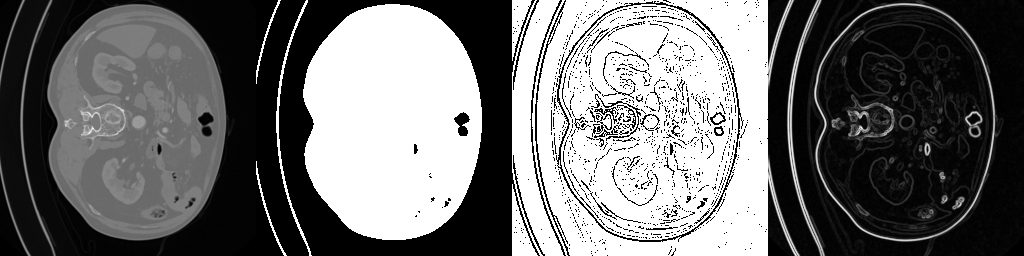

Threshold and Morphology Edge Detection for Image 2


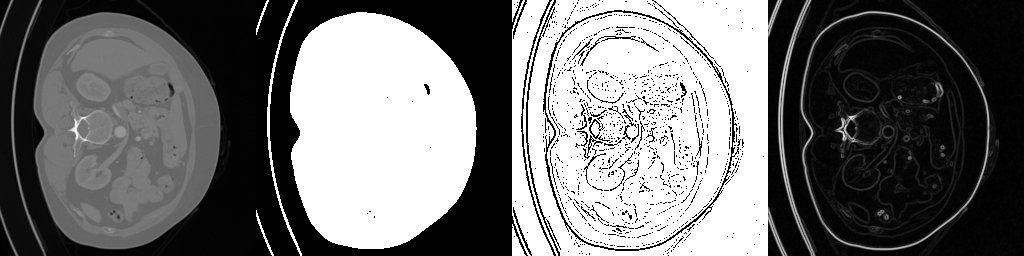

Threshold and Morphology Edge Detection for Image 3


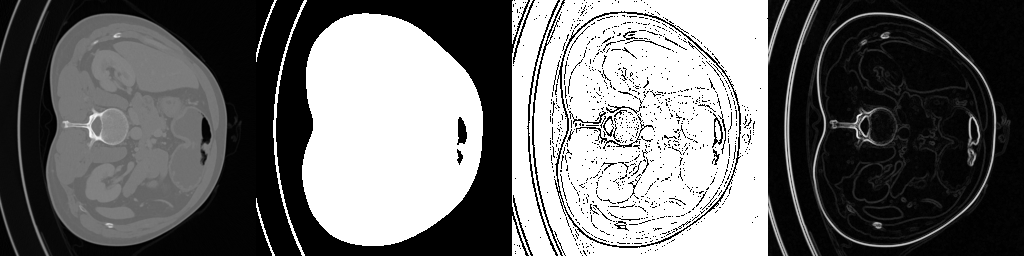

In [36]:
# Threshold yöntemleri
def detect_edges_otsu(img):
    _, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu

def detect_edges_adaptive(img):
    adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return adaptive

def detect_edges_morphology(img):
    kernel = disk(3)
    morphed = dilation(img, kernel) - erosion(img, kernel)
    morphed = (morphed / morphed.max() * 255).astype(np.uint8)
    return morphed

# Görselleri yan yana birleştirip gösterme
def display_images_side_by_side(images, title):
    concatenated = np.concatenate(images, axis=1)
    print(title)
    cv2_imshow(concatenated)

# Threshold ve morfolojik işlemlerle kenar tespiti ve görselleştirme
def advanced_edge_detection_and_display(image_sets, resize_dim):
    for i, img_set in enumerate(image_sets[:3]):
        original_image = cv2.resize(img_set[0], resize_dim)
        otsu_edges = cv2.resize(detect_edges_otsu(img_set[0]), resize_dim)
        adaptive_edges = cv2.resize(detect_edges_adaptive(img_set[0]), resize_dim)
        morphology_edges = cv2.resize(detect_edges_morphology(img_set[0]), resize_dim)

        # Tüm kenar tespiti sonuçlarını yan yana birleştir
        display_images_side_by_side(
            [original_image, otsu_edges, adaptive_edges, morphology_edges],
            f"Threshold and Morphology Edge Detection for Image {i+1}"
        )

# Yeni kenar tespit yöntemlerini uygula ve göster
advanced_edge_detection_and_display(preprocessed_images_list, resize_dim)

Image 1: Original | Otsu | Adaptive | Morphology | Label


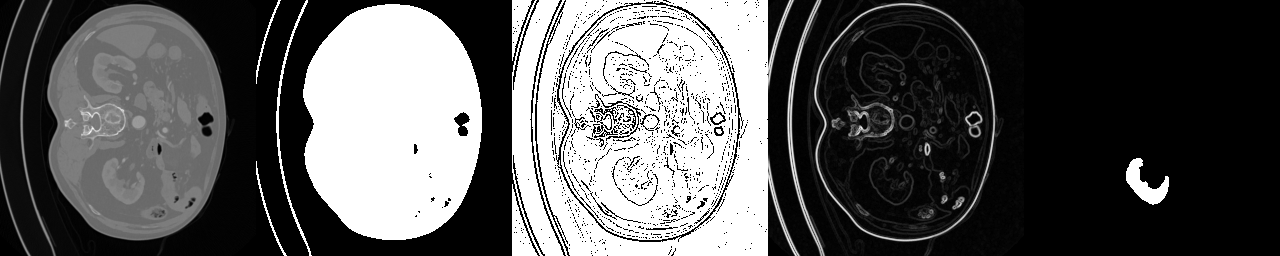

Image 2: Original | Otsu | Adaptive | Morphology | Label


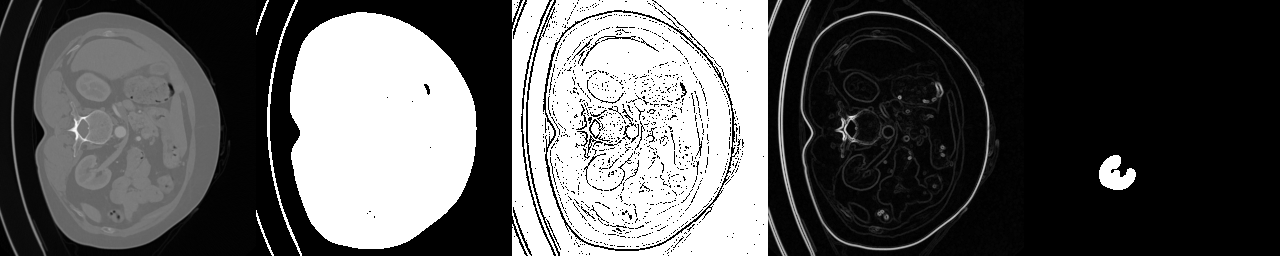

Image 3: Original | Otsu | Adaptive | Morphology | Label


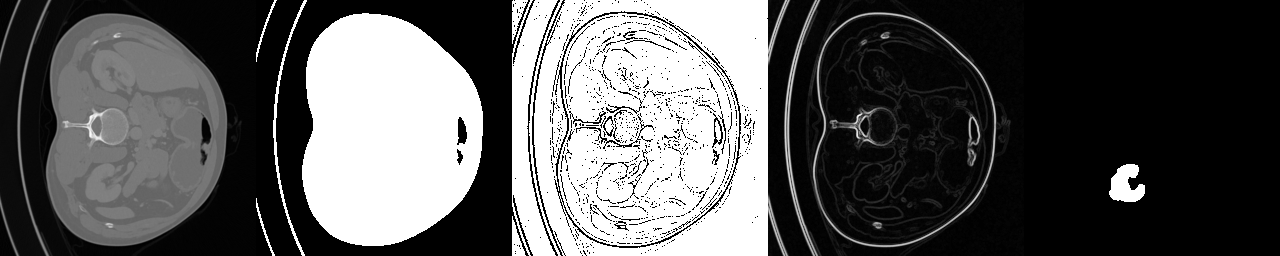

In [37]:
# Label görüntülerinin olduğu dizin
label_dir = "/content/drive/My Drive/Biyomedikal/DB/output_labels"

# Label görüntülerini yükleme
labels = [cv2.imread(os.path.join(label_dir, file), cv2.IMREAD_GRAYSCALE) for file in sorted(os.listdir(label_dir))]

# Orijinal görüntü, otsu, adaptive, morphology ve label görselleri birleştirme
def visualize_full_pipeline(original_images, preprocessed_image_sets, label_images, resize_dim):
    for i in range(3):  # İlk 3 görüntü
        original_resized = cv2.resize(original_images[i], resize_dim)
        otsu_edges = cv2.resize(detect_edges_otsu(preprocessed_image_sets[i][0]), resize_dim)
        adaptive_edges = cv2.resize(detect_edges_adaptive(preprocessed_image_sets[i][0]), resize_dim)
        morphology_edges = cv2.resize(detect_edges_morphology(preprocessed_image_sets[i][0]), resize_dim)
        label_resized = cv2.resize(label_images[i], resize_dim)

        # Görselleri yan yana birleştir
        concatenated = np.concatenate((original_resized, otsu_edges, adaptive_edges, morphology_edges, label_resized), axis=1)
        print(f"Image {i+1}: Original | Otsu | Adaptive | Morphology | Label")
        cv2_imshow(concatenated)

# Görselleştirme
visualize_full_pipeline(images, preprocessed_images_list, labels, resize_dim)


Label 1: 31 keypoints found.
Label 2: 20 keypoints found.
Label 3: 25 keypoints found.
SIFT Keypoint Visualization: All Labels


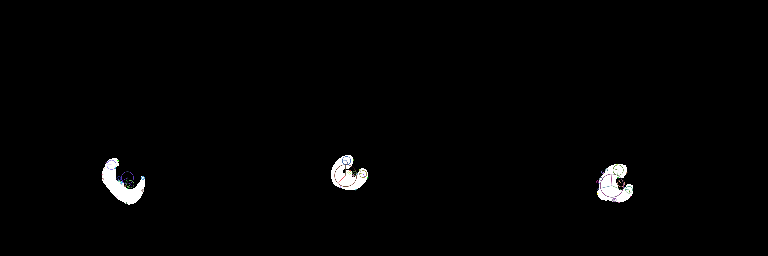

In [38]:
# SIFT ile anahtar nokta bulma ve görselleştirme (Yan yana ve optimize edilmiş)
def sift_and_visualize_labels_optimized(label_images, save_dir, resize_dim):
    # SIFT oluşturma
    sift = cv2.SIFT_create()

    # Kaydedilen görüntülerin klasörünü kontrol et
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Tüm görüntüleri yan yana birleştirme için liste
    all_images_concatenated = []

    for i, label in enumerate(label_images[:3]):  # İlk 3 label
        # Anahtar noktaları ve deskriptorları bul
        keypoints, descriptors = sift.detectAndCompute(label, None)

        # Anahtar noktaları görüntü üzerinde çiz
        keypoint_image = cv2.drawKeypoints(label, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # Görselleri yeniden boyutlandır
        keypoint_image_resized = cv2.resize(keypoint_image, resize_dim)

        # Görselleştirme
        print(f"Label {i+1}: {len(keypoints)} keypoints found.")

        # Kaydetme
        save_path = os.path.join(save_dir, f"label_{i+1}_sift_keypoints.png")
        cv2.imwrite(save_path, keypoint_image_resized)

        # Görüntüyü yan yana birleştirme için ekle
        all_images_concatenated.append(keypoint_image_resized)

    # Tüm görselleri yan yana birleştir
    concatenated_result = np.concatenate(all_images_concatenated, axis=1)  # Yan yana birleştirme
    print("SIFT Keypoint Visualization: All Labels")
    cv2_imshow(concatenated_result)

    # Yan yana birleştirilmiş görseli kaydet
    concatenated_save_path = os.path.join(save_dir, "sift_keypoints_combined.png")
    cv2.imwrite(concatenated_save_path, concatenated_result)

# Kaydetme klasörü
sift_save_dir = "/content/drive/My Drive/Biyomedikal/DB/sift_results"

# İlk 3 label üzerinde SIFT uygulama ve görselleştirme
sift_and_visualize_labels_optimized(labels, sift_save_dir, resize_dim)


In [39]:
import os
import cv2
import numpy as np

def extract_patches_from_sift(input_folder, output_folder, patch_size=24):
    """
    SIFT anahtar noktalarından patch'ler çıkarır ve sonuçları saklar.
    Args:
        input_folder: str, SIFT anahtar noktalarının bulunduğu görsellerin klasörü.
        output_folder: str, çıkarılan patch'lerin saklanacağı klasör.
        patch_size: int, patch boyutu (yarıçap).
    """
    os.makedirs(output_folder, exist_ok=True)

    # SIFT görselleri yükleme
    image_files = sorted(os.listdir(input_folder))

    for img_file in image_files:
        img_path = os.path.join(input_folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Görüntü yüklenemedi: {img_file}")
            continue

        # SIFT anahtar noktalarını tespit et
        sift = cv2.SIFT_create(contrastThreshold=0.02, edgeThreshold=10)
        keypoints, _ = sift.detectAndCompute(img, None)

        patches = []  # Patch'ler için bir liste
        for kp in keypoints:
            x, y = int(kp.pt[0]), int(kp.pt[1])

            # Patch sınırlarını kontrol et
            x_start, x_end = max(0, x - patch_size), min(img.shape[1], x + patch_size)
            y_start, y_end = max(0, y - patch_size), min(img.shape[0], y + patch_size)

            # Patch'i çıkar
            patch = img[y_start:y_end, x_start:x_end]
            if patch.shape == (2 * patch_size, 2 * patch_size):  # Tam boyutlu patch'ler
                patches.append(patch)

        # Patch'leri kaydet
        patch_output_path = os.path.join(output_folder, f"patches_{os.path.splitext(img_file)[0]}.npz")
        np.savez(patch_output_path, patches=patches)
        print(f"{img_file} için {len(patches)} patch çıkarıldı ve kaydedildi.")

# Kullanım
input_folder = "/content/drive/My Drive/Biyomedikal/DB/sift_results"  # SIFT görsellerin olduğu klasör
output_folder = "/content/drive/My Drive/Biyomedikal/DB/patches"  # Çıkarılacak patch'lerin kaydedileceği klasör

# Patch çıkarma işlemi
extract_patches_from_sift(input_folder=input_folder, output_folder=output_folder, patch_size=24)


label_1_sift_keypoints.png için 21 patch çıkarıldı ve kaydedildi.
label_2_sift_keypoints.png için 21 patch çıkarıldı ve kaydedildi.
label_3_sift_keypoints.png için 15 patch çıkarıldı ve kaydedildi.
sift_keypoints_combined.png için 57 patch çıkarıldı ve kaydedildi.


In [40]:
from skimage.feature import hog
import numpy as np
import os

def extract_hog_features(patch):
    """
    Tek bir patch için HOG özelliklerini hesaplar.
    Args:
        patch: NumPy dizisi, tekil patch.
    Returns:
        hog_features: NumPy dizisi, HOG özellikleri.
    """
    hog_features = hog(
        patch,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        orientations=9,
        block_norm='L2-Hys',
        visualize=False
    )
    return hog_features

def combine_patches_to_hog(input_folder, output_file):
    """
    Tüm patch dosyalarından HOG özelliklerini hesaplar ve tek bir dosyada birleştirir.
    Args:
        input_folder: str, patch dosyalarının bulunduğu klasör.
        output_file: str, birleştirilmiş HOG özelliklerinin kaydedileceği dosya.
    """
    all_hog_features = []  # Tüm görsellerin HOG özelliklerini saklar
    patch_counts = {}  # Her bir görselde kaç patch işlendiğini saklar

    # Çıkış dosyası için klasör yolunu oluştur
    output_folder = os.path.dirname(output_file)
    os.makedirs(output_folder, exist_ok=True)

    # Patch dosyalarını sırayla işle
    patch_files = sorted(os.listdir(input_folder))
    for patch_file in patch_files:
        patch_path = os.path.join(input_folder, patch_file)
        patch_data = np.load(patch_path)

        patches = patch_data['patches']
        patch_count = 0

        for patch in patches:
            # Patch'ten HOG özelliklerini çıkar
            hog_features = extract_hog_features(patch)
            all_hog_features.append(hog_features)
            patch_count += 1

        patch_counts[patch_file] = patch_count
        print(f"{patch_file} için toplam {patch_count} patch işlendi.")

    # HOG özelliklerini tek dosyada kaydet
    np.savez(output_file, features=np.array(all_hog_features))
    print(f"Tüm görseller için HOG özellikleri {output_file} dosyasına kaydedildi.")
    print(f"Görsel başına patch sayıları: {patch_counts}")

# Kullanım
input_folder = "/content/drive/My Drive/Biyomedikal/DB/patches"  # Patch'lerin bulunduğu klasör
output_file = "/content/drive/My Drive/Biyomedikal/DB/hog_features/hog_features.npz"  # Çıkış dosyası

# HOG özelliklerini çıkarma işlemi
combine_patches_to_hog(input_folder=input_folder, output_file=output_file)


patches_label_1_sift_keypoints.npz için toplam 21 patch işlendi.
patches_label_2_sift_keypoints.npz için toplam 21 patch işlendi.
patches_label_3_sift_keypoints.npz için toplam 15 patch işlendi.
patches_sift_keypoints_combined.npz için toplam 57 patch işlendi.
Tüm görseller için HOG özellikleri /content/drive/My Drive/Biyomedikal/DB/hog_features/hog_features.npz dosyasına kaydedildi.
Görsel başına patch sayıları: {'patches_label_1_sift_keypoints.npz': 21, 'patches_label_2_sift_keypoints.npz': 21, 'patches_label_3_sift_keypoints.npz': 15, 'patches_sift_keypoints_combined.npz': 57}


Test Aşaması


Image 1: Original | Label | Morphology Edges


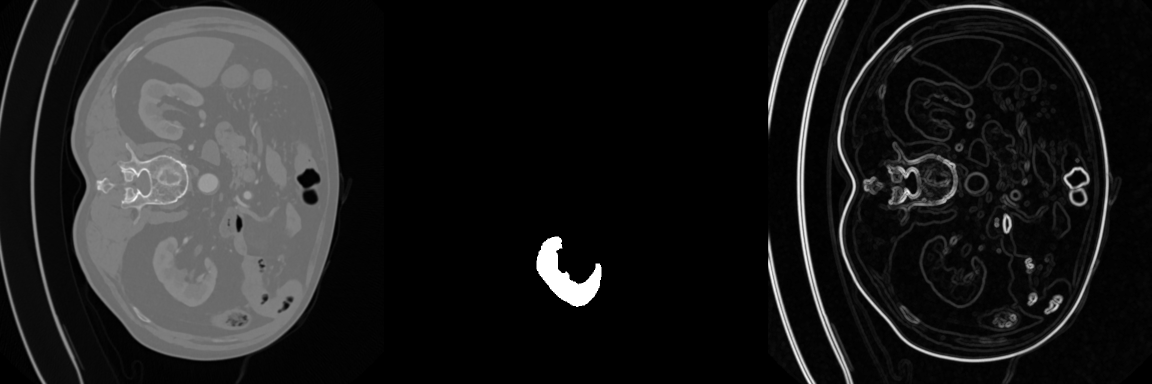

Image 2: Original | Label | Morphology Edges


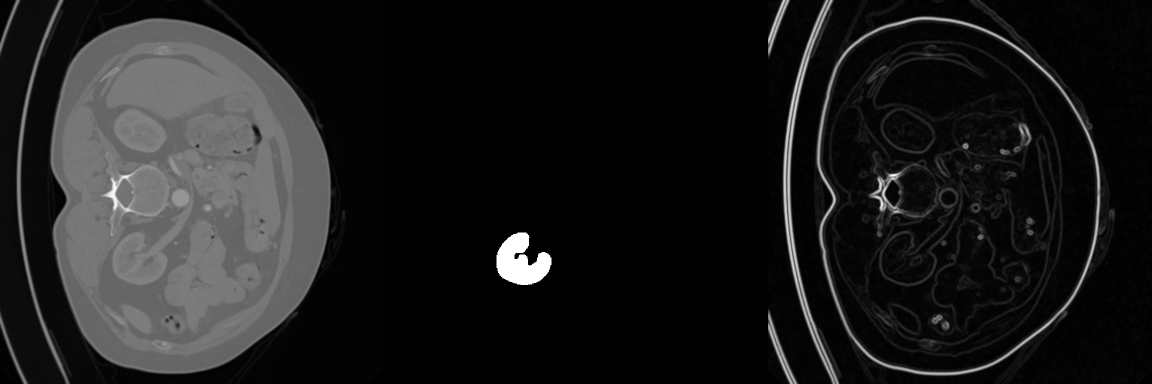

Image 3: Original | Label | Morphology Edges


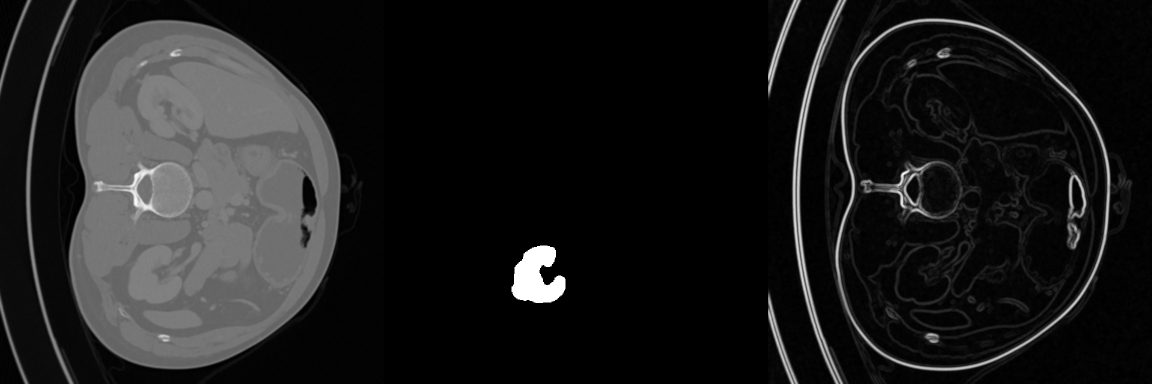

Image 4: Original | Label | Morphology Edges


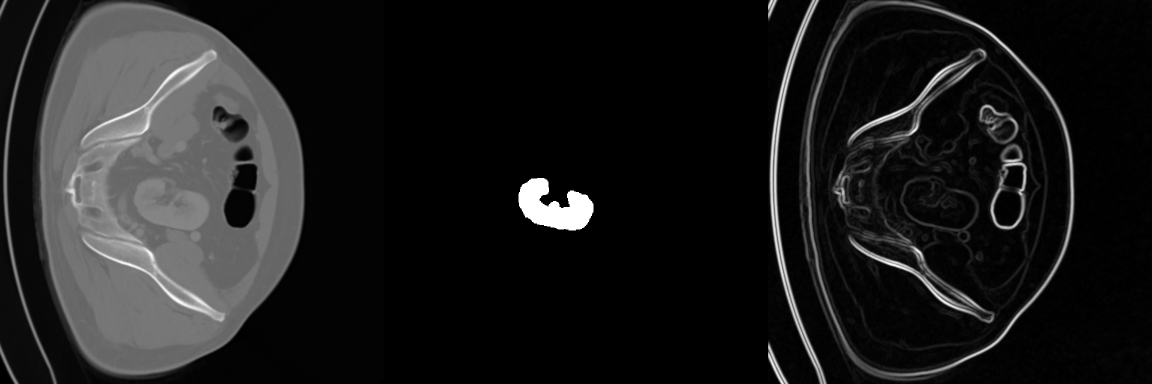

Image 5: Original | Label | Morphology Edges


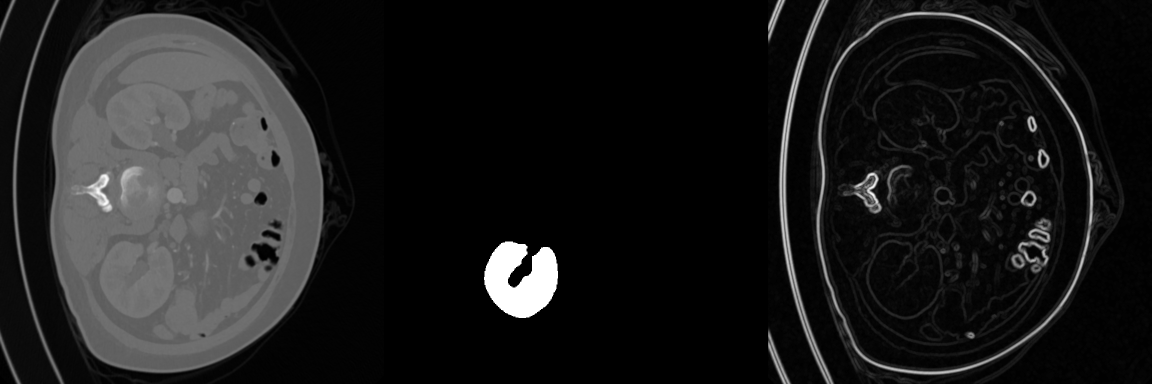

In [41]:
# Etiketlerin bulunduğu klasör
label_dir = "/content/drive/My Drive/Biyomedikal/DB/output_labels"

# Etiketleri yükleme
labels = [cv2.imread(os.path.join(label_dir, file), cv2.IMREAD_GRAYSCALE) for file in sorted(os.listdir(label_dir))]

# Orijinal görüntü, etiket ve kenar tespiti çıktısını yan yana gösterme
def display_images_with_morph_edges(images, labels, resize_dim):
    for i in range(len(images)):
        # Orijinal görüntü
        original_resized = cv2.resize(images[i], resize_dim)

        # Etiket (label) görüntüsü
        label_resized = cv2.resize(labels[i], resize_dim) if labels[i] is not None else np.zeros_like(original_resized)

        # Morfolojik kenar tespiti
        morphology_edges = detect_edges_morphology(images[i])
        morphology_edges_resized = cv2.resize(morphology_edges, resize_dim)

        # Görselleri birleştir: Orijinal | Label | Kenar Tespiti
        concatenated = np.concatenate((original_resized, label_resized, morphology_edges_resized), axis=1)

        # Görselleri ekrana bas
        print(f"Image {i+1}: Original | Label | Morphology Edges")
        cv2_imshow(concatenated)

# Görselleri etiketlerle birlikte göster
resize_dim = (384, 384)
display_images_with_morph_edges(images, labels, resize_dim)


Image 1 için 530 SIFT anahtar noktası bulundu ve kaydedildi.


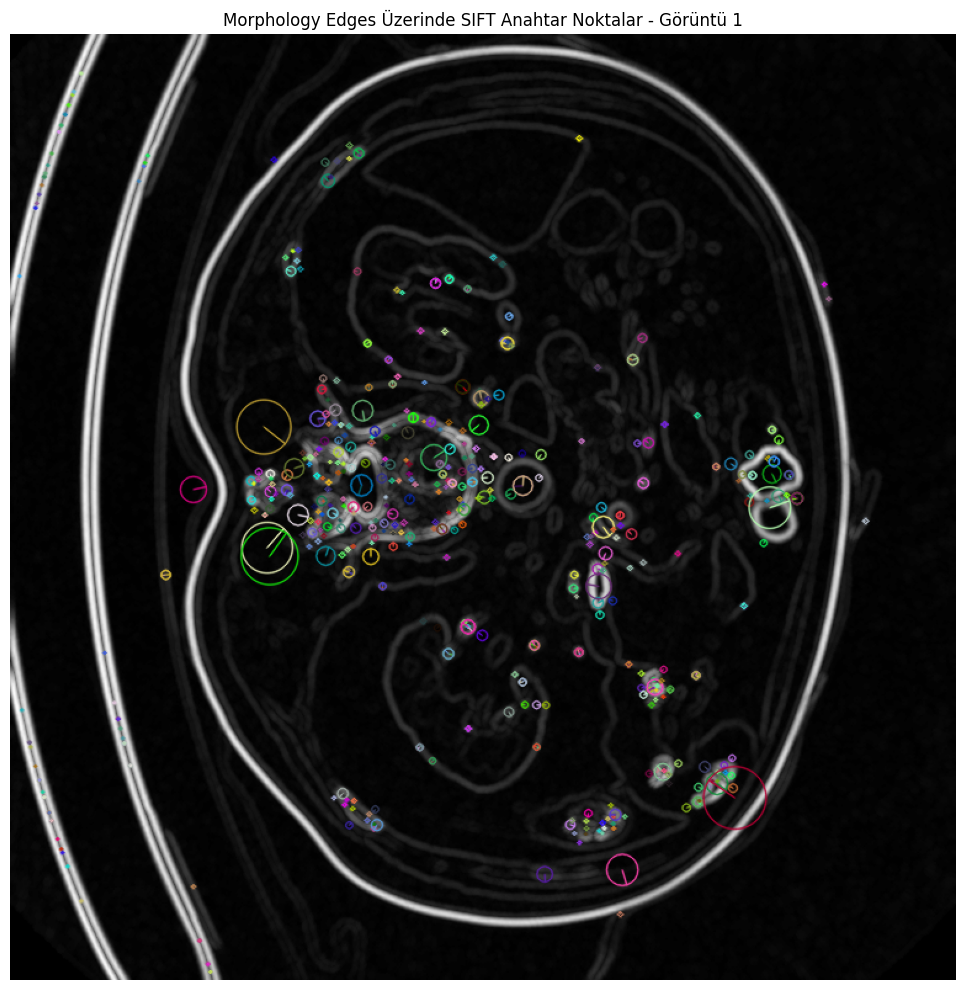

Image 2 için 276 SIFT anahtar noktası bulundu ve kaydedildi.


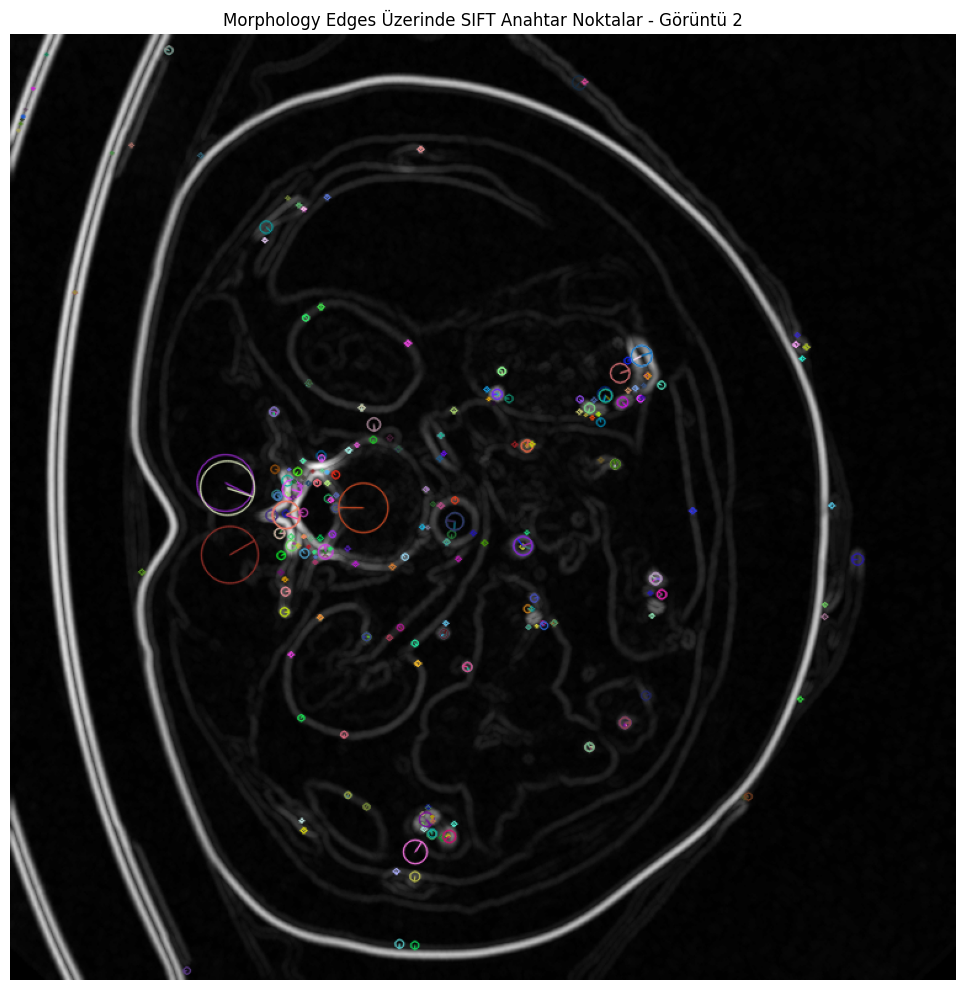

Image 3 için 275 SIFT anahtar noktası bulundu ve kaydedildi.


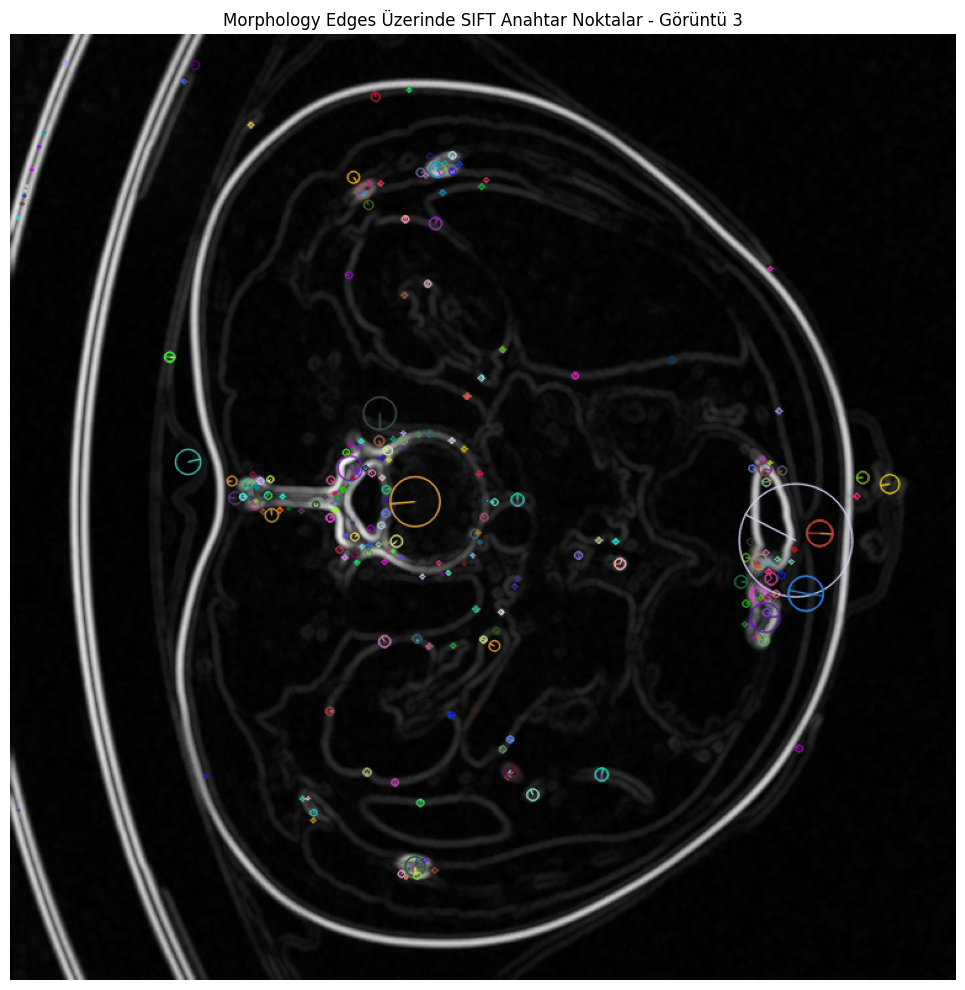

Image 4 için 361 SIFT anahtar noktası bulundu ve kaydedildi.


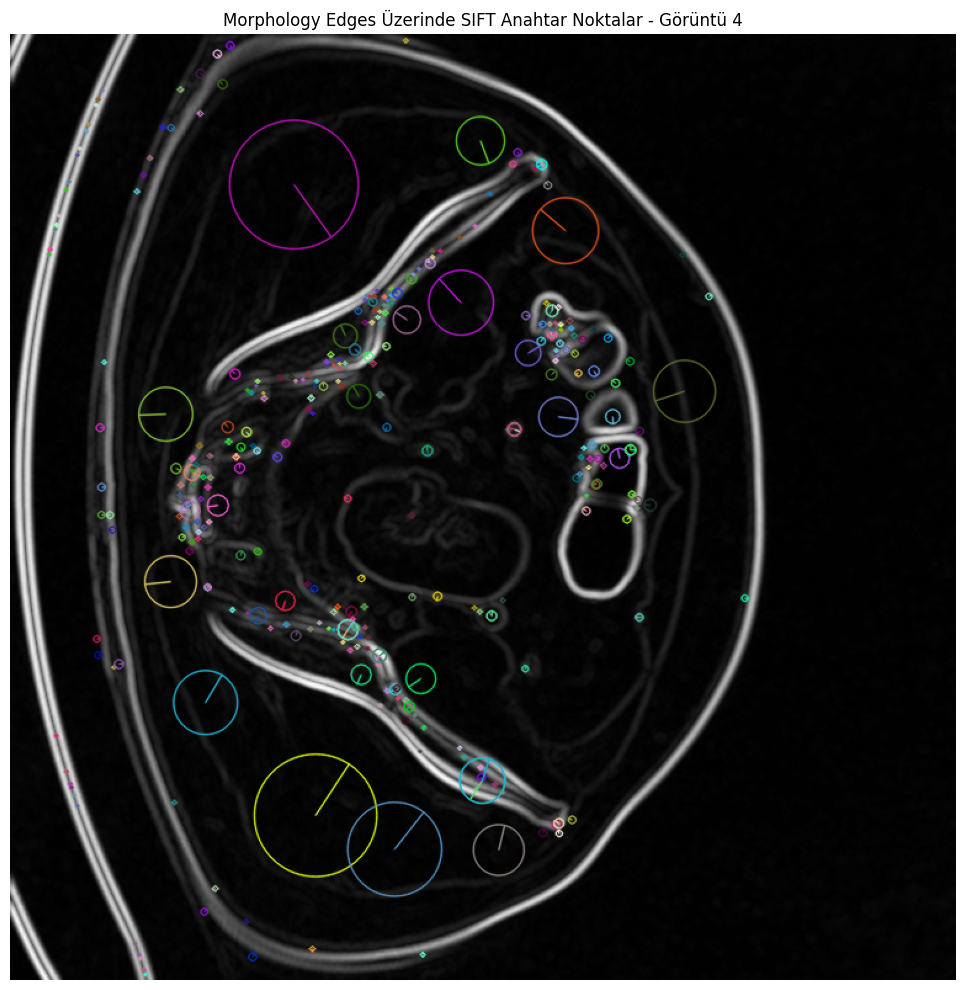

Image 5 için 339 SIFT anahtar noktası bulundu ve kaydedildi.


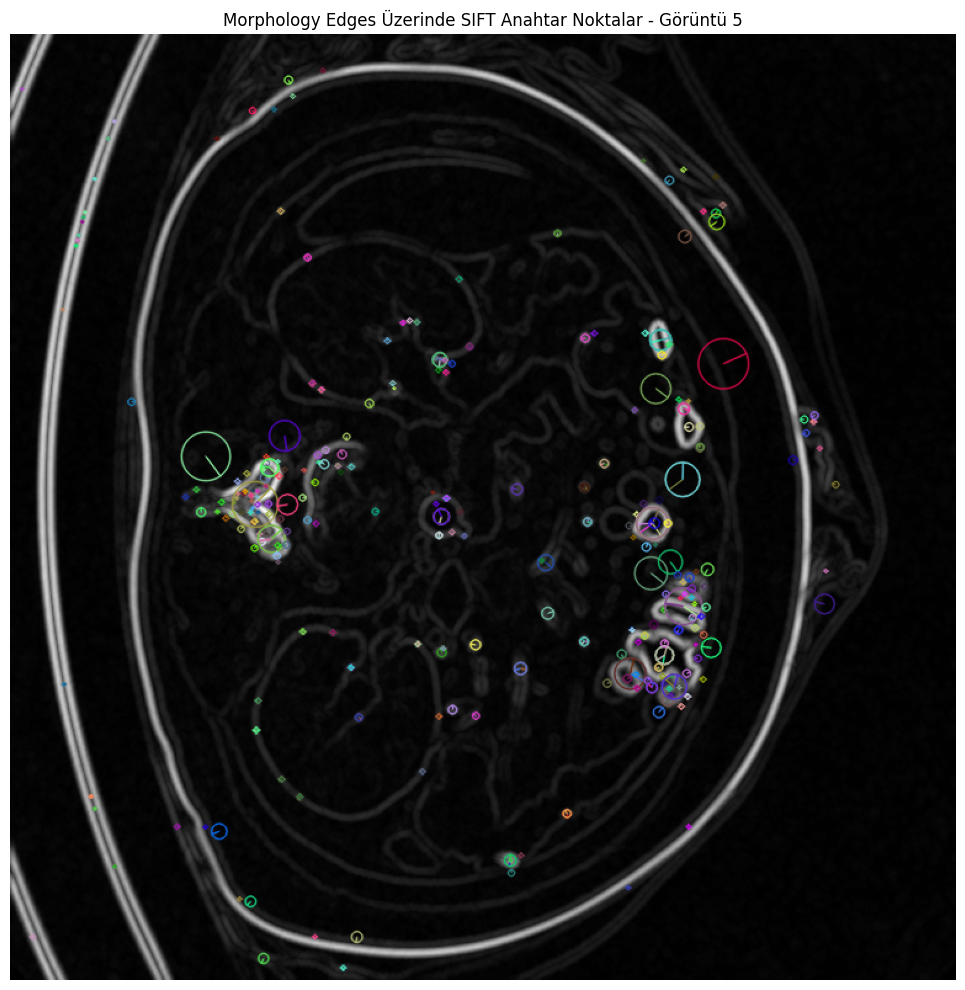

In [48]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

def sift_on_morphology_edges(images, morphology_edges, output_folder):
    """
    Morphology edges üzerinde SIFT anahtar noktalarını tespit eder ve sonucu kaydeder.

    Args:
        images: list, orijinal görüntülerin numpy array olarak listesi.
        morphology_edges: list, morfoloji kenar görüntüleri (list of numpy arrays).
        output_folder: str, SIFT görselleştirme sonuçlarının kaydedileceği klasör.
    """
    os.makedirs(output_folder, exist_ok=True)
    sift = cv2.SIFT_create()

    for i, (image, edge_image) in enumerate(zip(images, morphology_edges)):
        # SIFT anahtar noktalarını tespit et
        keypoints, _ = sift.detectAndCompute(edge_image, None)

        # Anahtar noktaları görselleştir
        img_with_keypoints = cv2.drawKeypoints(
            edge_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )

        # Sonucu kaydet
        result_path = os.path.join(output_folder, f"sift_morphology_{i+1}.png")
        cv2.imwrite(result_path, img_with_keypoints)

        # Konsolda bilgi ver
        print(f"Image {i+1} için {len(keypoints)} SIFT anahtar noktası bulundu ve kaydedildi.")

        # Görselleştir
        plt.figure(figsize=(10, 10))
        plt.title(f"Morphology Edges Üzerinde SIFT Anahtar Noktalar - Görüntü {i+1}")
        plt.imshow(img_with_keypoints, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Kullanım Örneği
if __name__ == "__main__":
    # Orijinal ve etiketli görüntülerin yolları
    image_dir = "/content/drive/My Drive/Biyomedikal/DB/output_images"
    label_dir = "/content/drive/My Drive/Biyomedikal/DB/output_labels"

    # Görüntüleri yükleme
    image_paths = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir)])
    label_paths = sorted([os.path.join(label_dir, file) for file in os.listdir(label_dir)])

    images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]
    labels = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in label_paths]

    # Morphology edges görüntülerini oluşturma
    morphology_edges = [detect_edges_morphology(image) for image in images]

    # SIFT sonuçlarının kaydedileceği klasör
    output_folder = "/content/drive/My Drive/Biyomedikal/DB/Morphology_SIFT"

    # SIFT anahtar noktalarını tespit et
    sift_on_morphology_edges(
        images=images,
        morphology_edges=morphology_edges,
        output_folder=output_folder
    )


In [50]:
from skimage.feature import hog
import numpy as np
import os

def extract_patches_hog_from_test_images(test_images, output_folder, patch_size=24):
    """
    Test görüntülerinden patch çıkarıp HOG özelliklerini hesaplar ve kaydeder.
    Args:
        test_images: list of np.array, test görüntüleri.
        output_folder: str, HOG özelliklerinin kaydedileceği klasör.
        patch_size: int, patch yarıçapı.
    """
    os.makedirs(output_folder, exist_ok=True)

    for i, image in enumerate(test_images):
        patches = []
        hog_features_list = []
        h, w = image.shape

        # Sliding window ile patch çıkarımı
        for y in range(0, h - patch_size * 2, patch_size):
            for x in range(0, w - patch_size * 2, patch_size):
                patch = image[y:y + 2 * patch_size, x:x + 2 * patch_size]
                if patch.shape == (2 * patch_size, 2 * patch_size):  # Patch boyut kontrolü
                    patches.append(patch)

                    # HOG özelliklerini hesapla
                    hog_features = hog(
                        patch,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        orientations=9,
                        block_norm='L2-Hys',
                        visualize=False
                    )
                    hog_features_list.append(hog_features)

        # Patch ve HOG özelliklerini kaydet
        output_file = os.path.join(output_folder, f"test_image_{i + 1}.npz")
        np.savez(output_file, patches=patches, hog_features=hog_features_list)
        print(f"Test görüntüsü {i + 1} için HOG özellikleri kaydedildi: {output_file}")


In [52]:
test_images = [cv2.imread(os.path.join(image_dir, file), cv2.IMREAD_GRAYSCALE) for file in sorted(os.listdir(image_dir))]
extract_patches_hog_from_test_images(test_images, "/content/drive/My Drive/Biyomedikal/DB/test_hog_features")


Test görüntüsü 1 için HOG özellikleri kaydedildi: /content/drive/My Drive/Biyomedikal/DB/test_hog_features/test_image_1.npz
Test görüntüsü 2 için HOG özellikleri kaydedildi: /content/drive/My Drive/Biyomedikal/DB/test_hog_features/test_image_2.npz
Test görüntüsü 3 için HOG özellikleri kaydedildi: /content/drive/My Drive/Biyomedikal/DB/test_hog_features/test_image_3.npz
Test görüntüsü 4 için HOG özellikleri kaydedildi: /content/drive/My Drive/Biyomedikal/DB/test_hog_features/test_image_4.npz
Test görüntüsü 5 için HOG özellikleri kaydedildi: /content/drive/My Drive/Biyomedikal/DB/test_hog_features/test_image_5.npz


In [51]:
def calculate_iou(prediction, label):
    """
    Tahmin ve etiket arasında IOU hesaplar.
    Args:
        prediction: np.array, tahmin maskesi.
        label: np.array, gerçek maskesi.
    Returns:
        iou: float, Intersection Over Union değeri.
    """
    intersection = np.logical_and(prediction, label).sum()
    union = np.logical_or(prediction, label).sum()
    return intersection / union if union != 0 else 0

def cross_correlation_and_iou(model_npz, test_npz_folder, labels, output_folder):
    """
    Cross korelasyon ile tahmin yapıp IOU hesaplar.
    Args:
        model_npz: str, modelden gelen HOG özelliklerinin dosya yolu.
        test_npz_folder: str, test görüntülerinin HOG özellik dosyalarının bulunduğu klasör.
        labels: list of np.array, gerçek etiket görüntüleri.
        output_folder: str, sonuçların kaydedileceği klasör.
    """
    os.makedirs(output_folder, exist_ok=True)

    # Model HOG özelliklerini yükle
    model_data = np.load(model_npz)
    model_features = model_data["features"]

    all_ious = []

    # Her test görüntüsünü işle
    test_files = sorted(os.listdir(test_npz_folder))
    for i, test_file in enumerate(test_files):
        test_data = np.load(os.path.join(test_npz_folder, test_file))
        test_hog_features = test_data["hog_features"]
        test_patches = test_data["patches"]

        # Cross korelasyon hesaplama
        best_score = -1
        best_patch_index = -1
        for j, test_feature in enumerate(test_hog_features):
            score = np.correlate(model_features.flatten(), test_feature.flatten())[0]
            if score > best_score:
                best_score = score
                best_patch_index = j

        # En iyi tahmini al
        best_patch = test_patches[best_patch_index]

        # IOU hesaplama
        resized_label = cv2.resize(labels[i], best_patch.shape[::-1], interpolation=cv2.INTER_NEAREST)
        iou = calculate_iou(best_patch > 127, resized_label > 127)
        all_ious.append(iou)

        # Sonuçları kaydet
        output_path = os.path.join(output_folder, f"result_{i + 1}.png")
        cv2.imwrite(output_path, best_patch)
        print(f"Görüntü {i + 1}: IOU = {iou:.4f}, Tahmin kaydedildi: {output_path}")

    # Ortalama IOU hesapla
    mean_iou = np.mean(all_ious)
    print(f"Ortalama IOU: {mean_iou:.4f}")


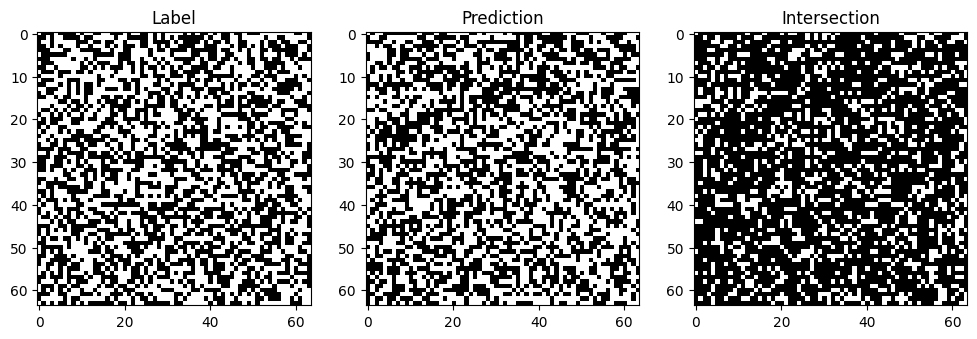

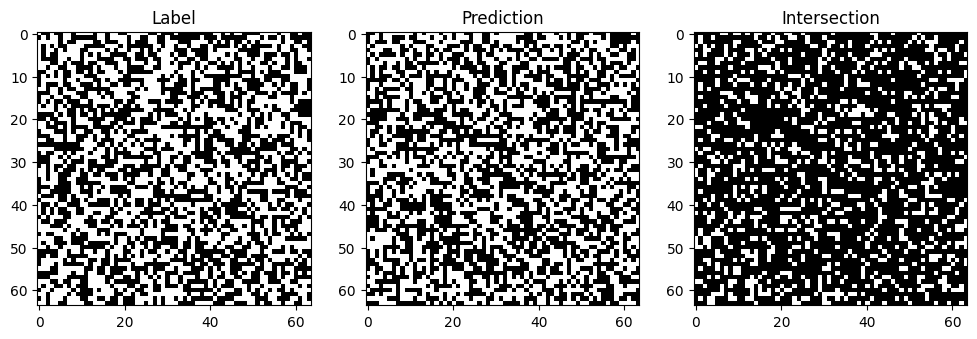

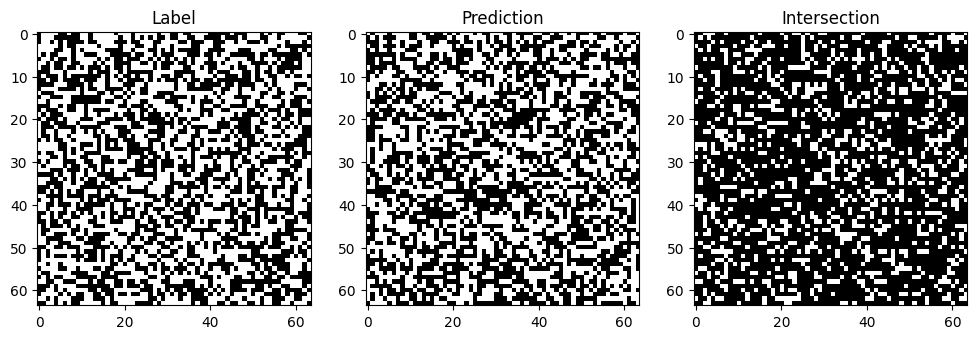

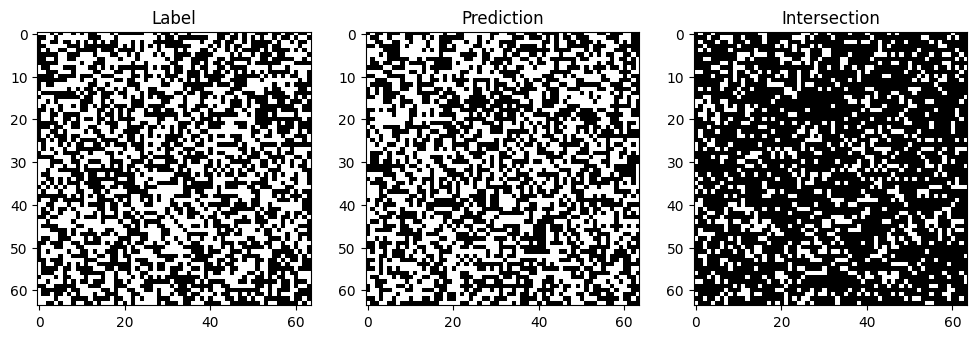

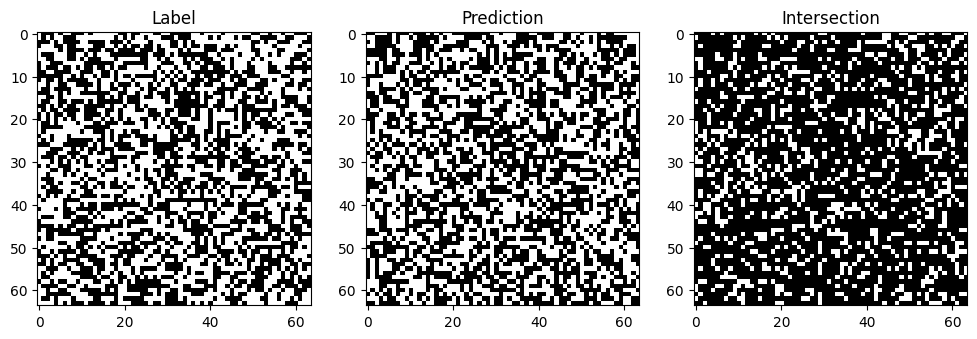

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np

# Örnek etiket ve tahmin verileri oluştur
labels = [np.random.randint(0, 2, (64, 64)) for _ in range(5)]  # 5 adet 64x64 etiket maskesi
predictions = [np.random.randint(0, 2, (64, 64)) for _ in range(5)]  # 5 adet 64x64 tahmin maskesi

# Tahmin ve etiket görselleştirme
for i in range(len(labels)):  # Tüm görüntüler için
    plt.figure(figsize=(12, 4))

    # Etiket maskesi
    plt.subplot(1, 3, 1)
    plt.title("Label")
    plt.imshow(labels[i], cmap='gray')

    # Tahmin maskesi
    plt.subplot(1, 3, 2)
    plt.title("Prediction")
    plt.imshow(predictions[i], cmap='gray')

    # Kesim (Intersection)
    plt.subplot(1, 3, 3)
    plt.title("Intersection")
    intersection = np.logical_and(labels[i], predictions[i])  # Kesim (1 olan bölgeler)
    plt.imshow(intersection, cmap='gray')

    plt.show()
